In [1]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Define datasets and directions
datasets = [
    "b4bqa"
    # orig filtered
    "medmcqa_orig_filtered",
    "medqa_4options_orig_filtered",
    # g2b
    "medqa_4options_g2b",
    "medqa_4options_g2b",
]

models = [
    "microsoft/phi-1",
    "microsoft/phi-1_5",
    "microsoft/phi-2",
    "microsoft/Phi-3-medium-4k-instruct",
    "mistralai/Mistral-7B-v0.3",
    "Qwen/Qwen1.5-7B",
    "meta-llama/Llama-2-7b-hf",
    "meta-llama/Meta-Llama-3-8B",
    "mistralai/Mixtral-8x7B-v0.1",
    "mistralai/Mixtral-8x22B-v0.1",
    "meta-llama/Llama-2-70B-hf",
    "meta-llama/Meta-Llama-3-70B",
    "Qwen/Qwen1.5-72B",
    "CohereForAI/c4ai-command-r-plus",
    "CohereForAI/aya-23-35B",
    "Qwen/Qwen2-72B",
    "Qwen/Qwen2-7B",
    "Qwen/Qwen1.5-110B",
    "01-ai/Yi-1.5-34B",
]

# Define a dictionary to map the original dataset names to the new names
model_name_map = {
    "microsoft-phi-1": "phi-1",
    "microsoft-phi-1_5": "phi-1_5",
    "microsoft-phi-2": "phi-2",
    "microsoft-Phi-3-medium-4k-instruct": "phi-3-medium",
    "CohereForAI-aya-23-35B": "c4ai-aya-23-35B",
    "CohereForAI-c4ai-command-r-plus": "c4ai-r-plus",
    "meta-llama-Llama-2-70B-hf": "llama-2-70B",
    "meta-llama-Llama-2-7b-hf": "llama-2-7B",
    "meta-llama-Meta-Llama-3-70B": "llama-3-70B",
    "meta-llama-Meta-Llama-3-8B": "llama-3-8B",
    "mistralai-Mixtral-8x22B-v0.1": "mixtral-8x22B",
    "mistralai-Mixtral-8x7B-v0.1": "mixtral-8x7B",
    "mistralai-Mistral-7B-v0.3": "mistral-7B",
    "Qwen-Qwen1.5-72B": "qwen1.5-72B",
    "Qwen-Qwen1.5-7B": "qwen1.5-7B",
    "Qwen-Qwen2-72B": "qwen1.5-72B",
    "Qwen-Qwen2-7B": "qwen1.5-7B",
    "Qwen-Qwen1.5-110B": "qwen1.5-110B",
    "01-ai-Yi-1.5-34B": "yi-1.5-34B",
}


model_size_map = {
    "phi-1": "1.3",
    "phi-1_5": "1.3",
    "phi-2": "2.7",
    "phi-3-medium": "14",
    "c4ai-aya-23-35B": "35",
    "c4ai-r-plus": "104",
    "llama-2-70B": "70",
    "llama-2-7B": "7",
    "llama-3-70B": "70",
    "llama-3-8B": "8",
    "mixtral-8x22B": "176",
    "mixtral-8x7B": "56",
    "mistral-7B": "7",
    "qwen1.5-72B": "72",
    "qwen1.5-7B": "7",
    "qwen2-72B": "72",
    "qwen2-7B": "7",
    "qwen1.5-110B": "110",
    "yi-1.5-34B": "34",
}


replacement_directions = ["generic_to_brand", "none"]

## Model results


In [7]:
def load_model_results(model, direction):
    """
    Load the model results from a JSON file.

    Args:
    model (str): The model name.
    direction (str): The direction of replacements (e.g., brand_to_generic, generic_to_brand).

    Returns:
    pd.DataFrame: A DataFrame containing the model results.
    """
    results_file_path = f"b4b/{model}_results.json"

    if os.path.exists(results_file_path):
        with open(results_file_path, "r") as file:
            results_data = json.load(file)

        results = results_data["results"]
        results_list = []

        for dataset, metrics in results.items():
            for metric, value in metrics.items():
                if metric.startswith("acc"):
                    metric_name = metric.split(",")[0]
                    results_list.append([dataset, metric_name, value])

        df_results = pd.DataFrame(results_list, columns=["Dataset", "Metric", "Value"])
        df_results["Model"] = model
        df_results["Dataset"] = df_results["Dataset"]

        return df_results
    else:
        return pd.DataFrame(columns=["Dataset", "Metric", "Value", "Model"])


def process_results(results_df):
    # Wrangle names to get pairs
    results_df["Direction"] = results_df["Dataset"].apply(
        lambda x: (
            "brand_to_generic"
            if "b2g" in x
            else "generic_to_brand" if "g2b" in x else "none"
        )
    )

    # If _b2g, _g2b, or b4b_ in name remove it from the name
    for term in ["_b2g", "_g2b", "b4b_", "_orig_filtered"]:
        results_df["Dataset"] = results_df["Dataset"].apply(
            lambda x: x.replace(term, "")
        )

    # Filter the results DataFrame to include only accuracy metrics
    results_df_filtered = results_df[results_df["Metric"] == "acc"]

    # filter out datasets if not contain medmcqa, medqa
    results_df_filtered = results_df_filtered[
        results_df_filtered["Dataset"].str.contains("medmcqa|medqa")
    ]

    # Pivot the DataFrame to have directions as columns
    pivot_results = results_df_filtered.pivot_table(
        index=["Dataset", "Model"], columns="Direction", values="Value"
    ).reset_index()

    # Replace 'b4b' with NaN
    pivot_results.replace("b4b", np.nan, inplace=True)

    # Drop the row with NaN
    pivot_results.dropna(subset=["Dataset"], inplace=True)

    # Calculate the average for each model
    average_df = (
        pivot_results.groupby("Model")[["generic_to_brand", "none"]]
        .mean()
        .reset_index()
    )

    # Assign the averages to 'b4b' dataset
    average_df["Dataset"] = "b4b"

    # Append the averages to the original DataFrame
    pivot_results = pd.concat([pivot_results, average_df], ignore_index=True)

    return pivot_results

In [8]:
# Initialize an empty DataFrame to store the final results
results_df = pd.DataFrame(columns=["Dataset", "Metric", "Value", "Model"])

# replace model / with - in the model name
for i in range(len(models)):
    models[i] = models[i].replace("/", "-")

# Load and store the model results
for model in models:
    for direction in replacement_directions:
        df_model_results = load_model_results(model, direction)
        if not df_model_results.empty:
            results_df = pd.concat([results_df, df_model_results], ignore_index=True)

# Save the results to a CSV file
results_output_file_path = "tables/all_model_results.csv"
results_df.to_csv(results_output_file_path, index=False)

print("\nModel Results found:")
print(results_df["Model"].unique())

processed_results = process_results(results_df)

# Assume processed_results is a pandas DataFrame and 'Model' is one of its columns
processed_results["Model"] = (
    processed_results["Model"].map(model_name_map).fillna(processed_results["Model"])
)


# sort by dataset and model
processed_results = processed_results.sort_values(by=["Dataset", "Model"])

processed_results_output_file_path = "tables/processed_model_results.csv"

# Save the processed results to a CSV file
processed_results.to_csv(processed_results_output_file_path, index=False)
processed_results


Model Results found:
['microsoft-phi-1' 'microsoft-phi-1_5' 'microsoft-phi-2'
 'microsoft-Phi-3-medium-4k-instruct' 'mistralai-Mistral-7B-v0.3'
 'meta-llama-Llama-2-7b-hf' 'meta-llama-Meta-Llama-3-8B'
 'mistralai-Mixtral-8x7B-v0.1' 'meta-llama-Llama-2-70B-hf'
 'meta-llama-Meta-Llama-3-70B' 'CohereForAI-c4ai-command-r-plus'
 'CohereForAI-aya-23-35B' 'Qwen-Qwen2-72B' 'Qwen-Qwen2-7B']


/tmp/ipykernel_3577470/2460208478.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, df_model_results], ignore_index=True)


Direction,Dataset,Model,generic_to_brand,none
28,b4b,c4ai-aya-23-35B,0.482234,0.519659
29,b4b,c4ai-r-plus,0.528758,0.609059
32,b4b,llama-2-70B,0.493113,0.536627
33,b4b,llama-2-7B,0.341498,0.357485
34,b4b,llama-3-70B,0.697090,0.766466
35,b4b,llama-3-8B,0.539500,0.600210
40,b4b,mistral-7B,0.484766,0.550356
41,b4b,mixtral-8x7B,0.577563,0.636882
37,b4b,phi-1,0.229155,0.233808
38,b4b,phi-1_5,0.332649,0.325579


get b4b qa results

In [9]:
results_df
# keep only rows where Dataset=='b4bqa' and Metric=='acc'
b4bqa_results = results_df[
    (results_df["Dataset"] == "b4bqa") & (results_df["Metric"] == "acc")
]
# deduplicate the results
b4bqa_results = b4bqa_results.drop_duplicates(subset=["Model"])
# sort the results by Model size
b4bqa_results["Model Size"] = (
    b4bqa_results["Model"].map(model_name_map).map(model_size_map)
)
b4bqa_results["Model Size"] = pd.to_numeric(b4bqa_results["Model Size"])
b4bqa_results = b4bqa_results.sort_values(by="Model Size")

# drop column direction and metric
b4bqa_results = b4bqa_results.drop(columns=["Direction", "Metric", "Dataset"])

b4bqa_results

,Value,Model,Model Size
4,0.196429,microsoft-phi-1,1.3
52,0.280134,microsoft-phi-1_5,1.3
100,0.474888,microsoft-phi-2,2.7
196,0.703125,mistralai-Mistral-7B-v0.3,7.0
244,0.368304,meta-llama-Llama-2-7b-hf,7.0
628,0.804129,Qwen-Qwen2-7B,7.0
292,0.827009,meta-llama-Meta-Llama-3-8B,8.0
148,0.699777,microsoft-Phi-3-medium-4k-instruct,14.0
532,0.784040,CohereForAI-aya-23-35B,35.0
340,0.861049,mistralai-Mixtral-8x7B-v0.1,56.0


/tmp/ipykernel_3577470/999547938.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Value", data=b4bqa_results, palette="viridis")


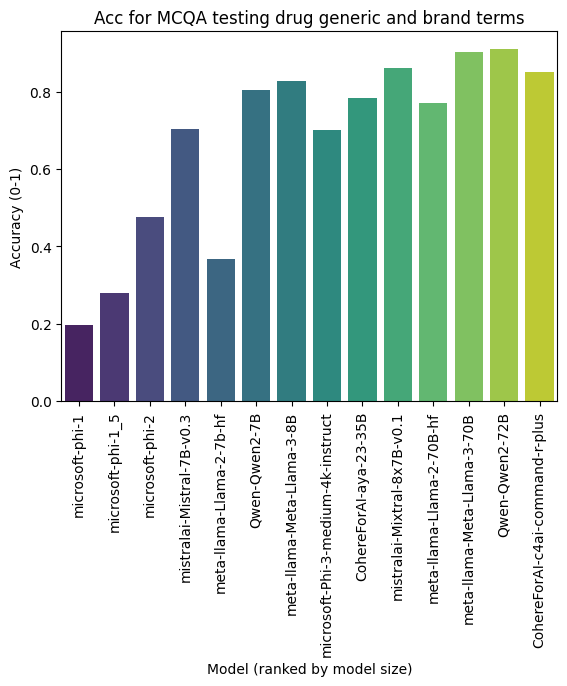

In [10]:
sns.barplot(x="Model", y="Value", data=b4bqa_results, palette="viridis")

plt.title("Acc for MCQA testing drug generic and brand terms")
plt.xlabel("Model (ranked by model size)")
plt.ylabel("Accuracy (0-1)")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.show()

## Latex tables

#### Dataset | Model | brand_to_generic | generic_to_brand | none


In [11]:
# Generate LaTeX table
latex_table = processed_results.to_latex(index=False, float_format="%.3f")

# Save LaTeX table to a file
with open("tables/model_results_table.tex", "w") as f:
    f.write(latex_table)
# Print the LaTeX table
## # Dataset | Model | brand_to_generic | generic_to_brand | none
print(latex_table)

\begin{tabular}{llrr}
\toprule
Dataset & Model & generic_to_brand & none \\
\midrule
b4b & c4ai-aya-23-35B & 0.482 & 0.520 \\
b4b & c4ai-r-plus & 0.529 & 0.609 \\
b4b & llama-2-70B & 0.493 & 0.537 \\
b4b & llama-2-7B & 0.341 & 0.357 \\
b4b & llama-3-70B & 0.697 & 0.766 \\
b4b & llama-3-8B & 0.540 & 0.600 \\
b4b & mistral-7B & 0.485 & 0.550 \\
b4b & mixtral-8x7B & 0.578 & 0.637 \\
b4b & phi-1 & 0.229 & 0.234 \\
b4b & phi-1_5 & 0.333 & 0.326 \\
b4b & phi-2 & 0.397 & 0.431 \\
b4b & phi-3-medium & 0.569 & 0.654 \\
b4b & qwen1.5-72B & 0.728 & 0.766 \\
b4b & qwen1.5-7B & 0.544 & 0.613 \\
medmcqa & c4ai-aya-23-35B & 0.486 & 0.529 \\
medmcqa & c4ai-r-plus & 0.491 & 0.615 \\
medmcqa & llama-2-70B & 0.460 & 0.523 \\
medmcqa & llama-2-7B & 0.339 & 0.342 \\
medmcqa & llama-3-70B & 0.667 & 0.782 \\
medmcqa & llama-3-8B & 0.529 & 0.592 \\
medmcqa & mistral-7B & 0.483 & 0.569 \\
medmcqa & mixtral-8x7B & 0.555 & 0.649 \\
medmcqa & phi-1 & 0.241 & 0.259 \\
medmcqa & phi-1_5 & 0.316 & 0.305 \\
medmcqa &

### Model | none | generic_to_brand | Average | Difference


In [12]:
# Filter for the 'b4b' dataset
b4b_results = processed_results[processed_results["Dataset"] == "b4b"].copy()

# Calculate the average of original (none) and generic to brand
b4b_results["Average"] = b4b_results[["none", "generic_to_brand"]].mean(axis=1)

# Calculate the difference
b4b_results["Difference"] = b4b_results["generic_to_brand"] - b4b_results["none"]

# Select relevant columns for the LaTeX table
b4b_results = b4b_results[
    ["Model", "none", "generic_to_brand", "Average", "Difference"]
]

# Generate LaTeX table
latex_table_b4b = b4b_results.to_latex(index=False, float_format="%.3f")

# Save LaTeX table to a file
with open("tables/b4b_results_table.tex", "w") as f:
    f.write(latex_table_b4b)

# Print the LaTeX table
## # Model | none | generic_to_brand | Average | Difference
print(latex_table_b4b)

\begin{tabular}{lrrrr}
\toprule
Model & none & generic_to_brand & Average & Difference \\
\midrule
c4ai-aya-23-35B & 0.520 & 0.482 & 0.501 & -0.037 \\
c4ai-r-plus & 0.609 & 0.529 & 0.569 & -0.080 \\
llama-2-70B & 0.537 & 0.493 & 0.515 & -0.044 \\
llama-2-7B & 0.357 & 0.341 & 0.349 & -0.016 \\
llama-3-70B & 0.766 & 0.697 & 0.732 & -0.069 \\
llama-3-8B & 0.600 & 0.540 & 0.570 & -0.061 \\
mistral-7B & 0.550 & 0.485 & 0.518 & -0.066 \\
mixtral-8x7B & 0.637 & 0.578 & 0.607 & -0.059 \\
phi-1 & 0.234 & 0.229 & 0.231 & -0.005 \\
phi-1_5 & 0.326 & 0.333 & 0.329 & 0.007 \\
phi-2 & 0.431 & 0.397 & 0.414 & -0.034 \\
phi-3-medium & 0.654 & 0.569 & 0.612 & -0.085 \\
qwen1.5-72B & 0.766 & 0.728 & 0.747 & -0.038 \\
qwen1.5-7B & 0.613 & 0.544 & 0.578 & -0.068 \\
\bottomrule
\end{tabular}



## Visualise difference in performance


In [13]:
# Calculate the differences
processed_results["Diff_generic_to_brand"] = (
    processed_results["generic_to_brand"] - processed_results["none"]
)

# Melt the DataFrame for plotting
melted_results = processed_results.melt(
    id_vars=["Dataset", "Model"],
    value_vars=["Diff_generic_to_brand"],
    var_name="Direction",
    value_name="Accuracy Difference",
)

melted_results

,Dataset,Model,Direction,Accuracy Difference
0,b4b,c4ai-aya-23-35B,Diff_generic_to_brand,-0.037425
1,b4b,c4ai-r-plus,Diff_generic_to_brand,-0.080300
2,b4b,llama-2-70B,Diff_generic_to_brand,-0.043514
3,b4b,llama-2-7B,Diff_generic_to_brand,-0.015987
4,b4b,llama-3-70B,Diff_generic_to_brand,-0.069376
5,b4b,llama-3-8B,Diff_generic_to_brand,-0.060710
6,b4b,mistral-7B,Diff_generic_to_brand,-0.065590
7,b4b,mixtral-8x7B,Diff_generic_to_brand,-0.059319
8,b4b,phi-1,Diff_generic_to_brand,-0.004652
9,b4b,phi-1_5,Diff_generic_to_brand,0.007070


/tmp/ipykernel_3577470/2584561217.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_3577470/2584561217.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_3577470/2584561217.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_3577470/2584561217.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_3577470/2584561217.py:25: FutureWarning: 

Passing `palet

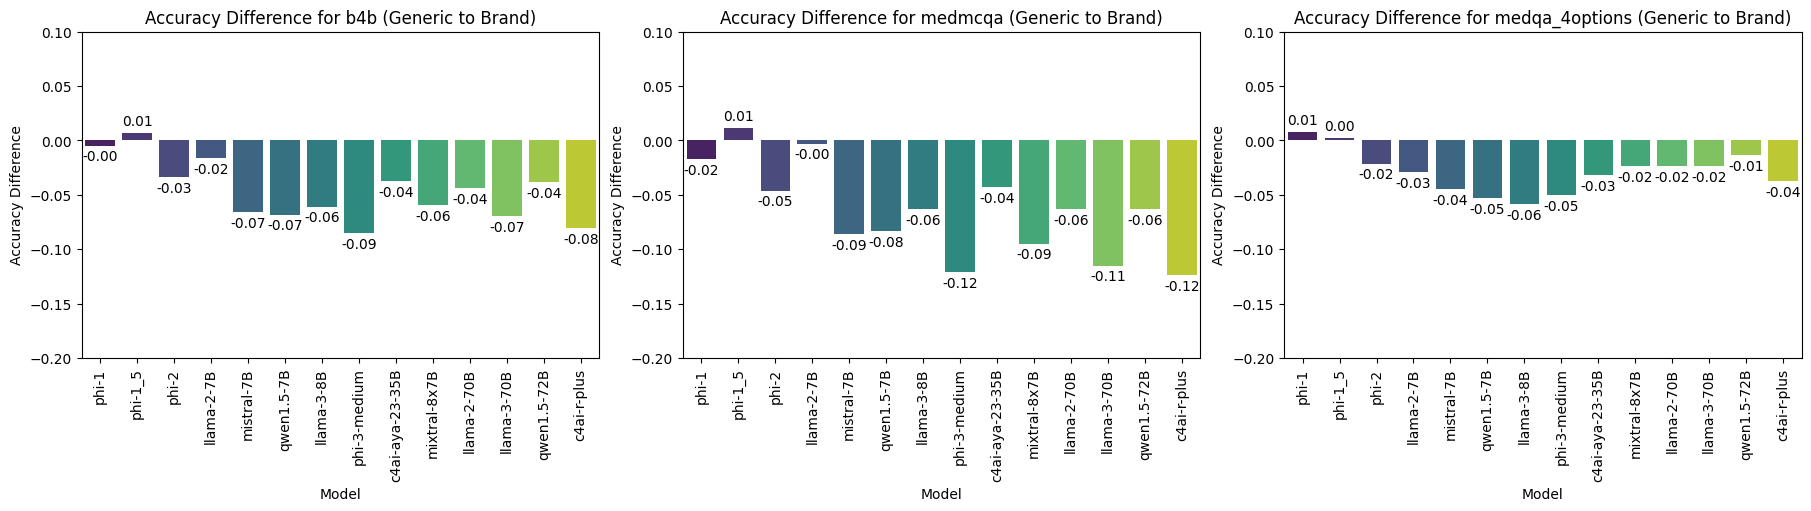

In [14]:
# Filter the DataFrame to only include 'Diff_generic_to_brand' direction
filtered_results = melted_results[
    melted_results["Direction"] == "Diff_generic_to_brand"
]

# Create a new column 'Model Size' in the DataFrame
filtered_results["Model Size"] = filtered_results["Model"].map(model_size_map)
filtered_results["Model Size"] = pd.to_numeric(filtered_results["Model Size"])

# Create bar plots for each task with filtered data
tasks = filtered_results["Dataset"].unique()
num_tasks = len(tasks)
ncols = 3  # Number of columns in the grid
nrows = (num_tasks // ncols) + (num_tasks % ncols > 0)  # Number of rows needed

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(18, nrows * 5), constrained_layout=True
)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, task in enumerate(tasks):
    ax = axes[i]
    task_data = filtered_results[filtered_results["Dataset"] == task]
    task_data = task_data.sort_values("Model Size")  # Sort by Model Size
    sns.barplot(
        x="Model",
        y="Accuracy Difference",
        data=task_data,
        palette="viridis",
        ax=ax,
        order=task_data["Model"],
    )

    # Add labels on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

    ax.set_title(f"Accuracy Difference for {task} (Generic to Brand)")
    ax.set_xlabel("Model")
    ax.set_ylabel("Accuracy Difference")
    ax.set_ylim(-0.2, 0.1)  # Adjust the y-axis limits as needed

    # Rotate the x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Save the plot to a file
plt.savefig("plots/accuracy_difference_generic_to_brand.png")

plt.show()

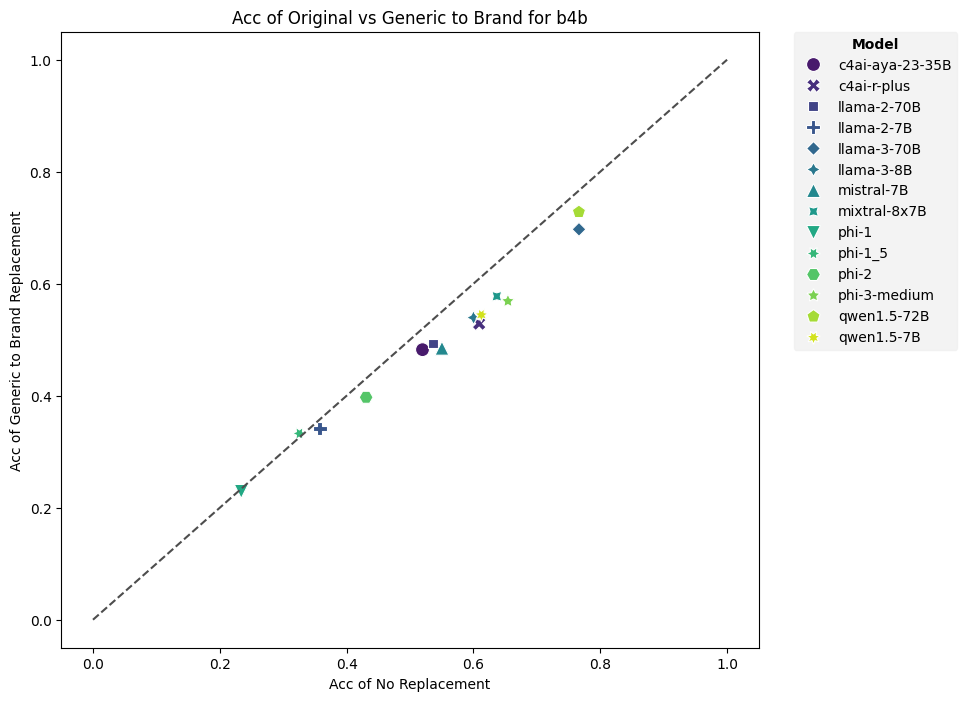

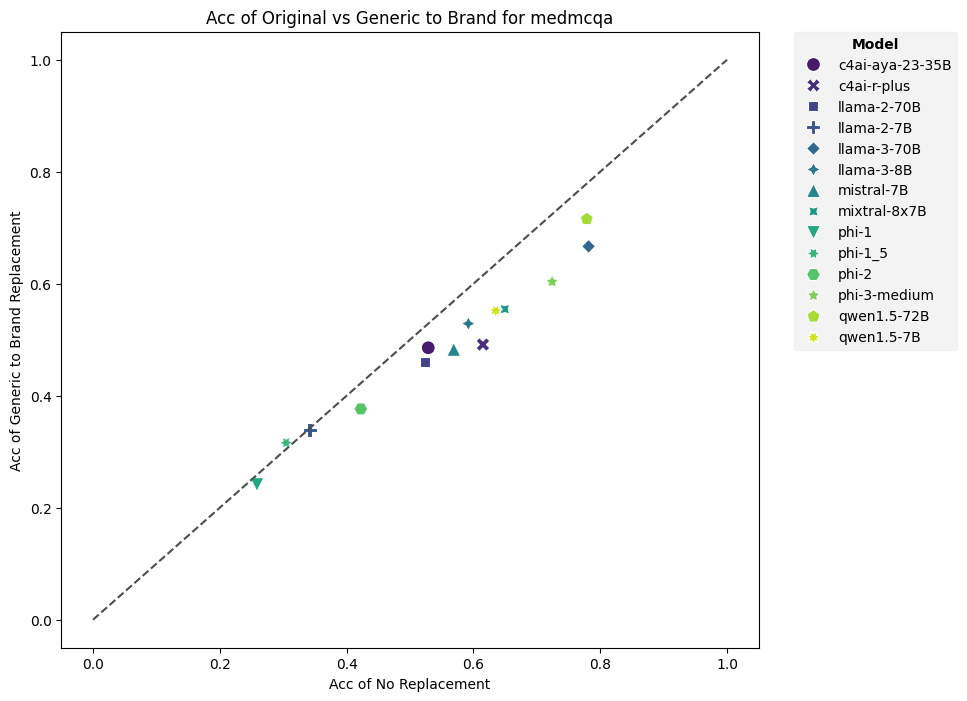

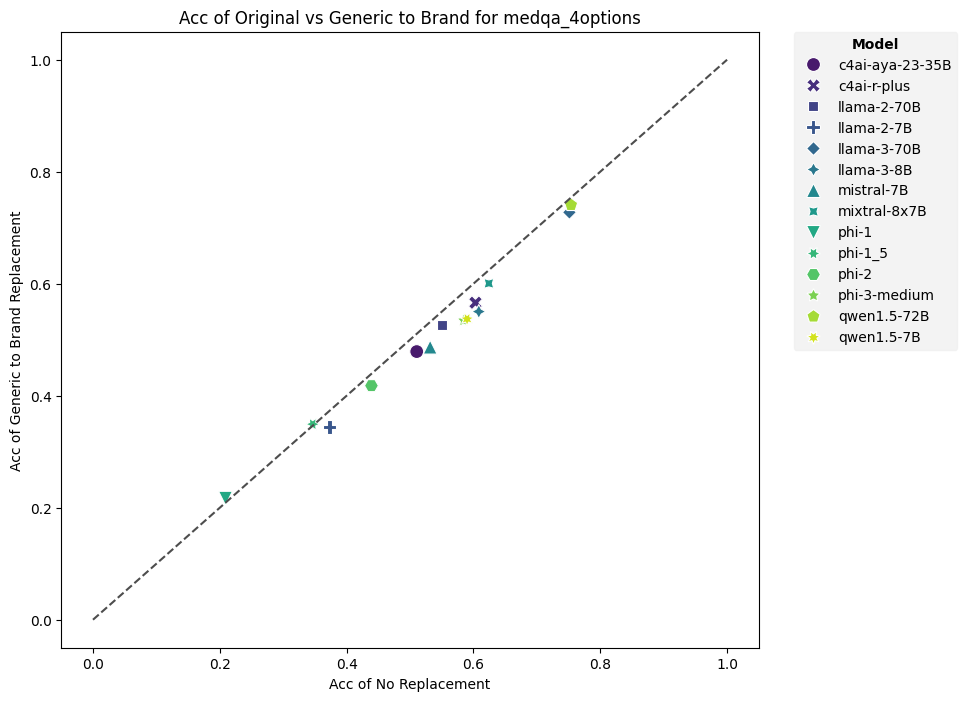

In [15]:
# Get the unique tasks
tasks = processed_results["Dataset"].unique()

for task in tasks:
    task_data = processed_results[processed_results["Dataset"] == task]

    # Setting up the figure and axis for generic_to_brand scatter plot
    plt.figure(figsize=(9, 8))
    ax2 = sns.scatterplot(
        data=task_data,
        x="none",
        y="generic_to_brand",
        hue="Model",
        style="Model",
        palette="viridis",
        s=100,
    )
    ax2.plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal line
    ax2.set_title(f"Acc of Original vs Generic to Brand for {task}")
    ax2.set_xlabel("Acc of No Replacement")
    ax2.set_ylabel("Acc of Generic to Brand Replacement")

    # Configure and place the legend outside the plot with a grey background
    legend = ax2.legend(
        title="Model", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, frameon=True
    )
    legend.get_frame().set_color("#f0f0f0")  # Set legend background color
    plt.setp(legend.get_title(), weight="bold")  # Make legend title bold
    plt.savefig(f"plots/{task}_generic_to_brand.png")
    plt.show()  # Display the plot in the notebook

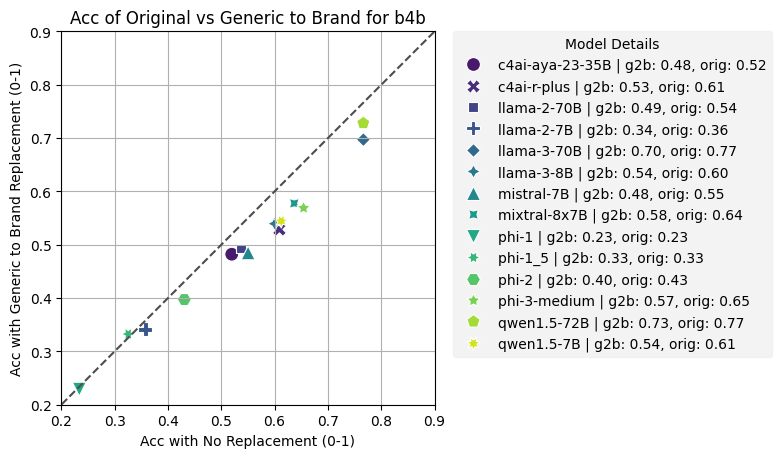

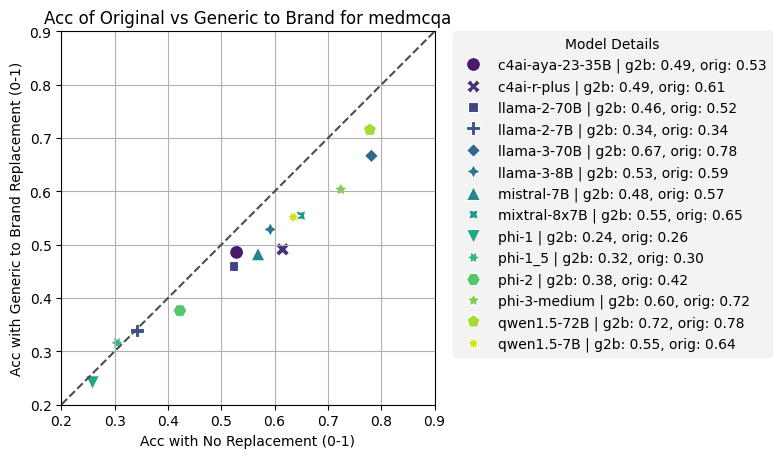

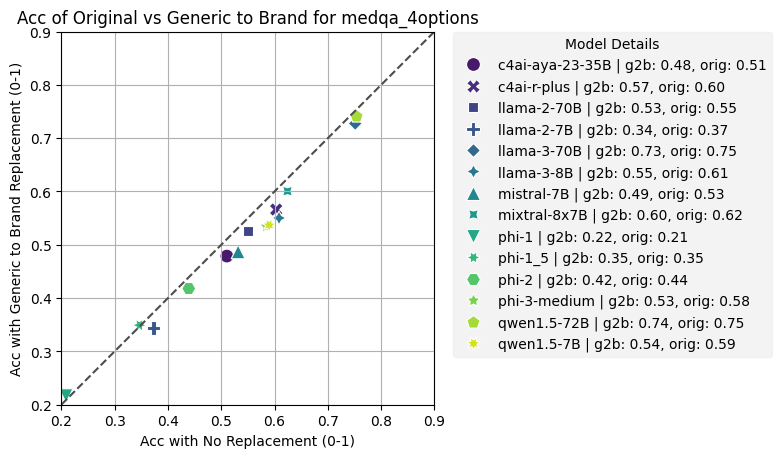

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume 'processed_results' is your DataFrame
processed_results["Model_g2b_detail"] = processed_results.apply(
    lambda x: f"{x['Model']} | g2b: {x['generic_to_brand']:.2f}, orig: {x['none']:.2f}",
    axis=1,
)

# Get the unique tasks
tasks = processed_results["Dataset"].unique()

for task in tasks:
    task_data = processed_results[processed_results["Dataset"] == task]

    # Scatter plot for generic_to_brand vs none
    plt.figure(figsize=(8, 8))
    ax2 = sns.scatterplot(
        data=task_data,
        x="none",
        y="generic_to_brand",
        hue="Model_g2b_detail",  # Use detailed label for hue
        style="Model_g2b_detail",  # Use detailed label for style
        palette="viridis",
        s=100,
    )
    ax2.set_xlim([0.2, 0.9])  # Set x-axis range
    ax2.set_ylim([0.2, 0.9])
    ax2.plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal reference line
    ax2.set_aspect("equal", adjustable="box")
    ax2.set_title(f"Acc of Original vs Generic to Brand for {task}", loc="center")
    ax2.set_xlabel("Acc with No Replacement (0-1)")
    ax2.set_ylabel("Acc with Generic to Brand Replacement (0-1)")
    ax2.grid(True)

    # Configure and place the legend outside the plot
    legend = ax2.legend(
        title="Model Details",
        bbox_to_anchor=(1.05, 1),
        loc=2,
        borderaxespad=0.0,
        frameon=True,
    )
    legend.get_frame().set_color("#f0f0f0")
    plt.tight_layout()
    plt.savefig(f"plots/{task}_generic_to_brand.png")
    plt.show()

In [ ]:
# read in keywords count for each dataset (raw file in b4b repo)
keywords_count = pd.read_csv("keywords_count_test.csv")

keywords_count

,dataset,split,n_questions,keywords,total_keyword_length,brand_keywords_count,generic_keywords_count
0,medmcqa,test,780,"['carbamide', 'ofloxacin', 'lamivudine', 'nevi...",1359,67,1292
1,bigbio/pubmed_qa,test,23,"['digoxin', 'supreme', 'methotrexate', 'fenofi...",23,1,22
2,GBaker/MedQA-USMLE-4-options-hf,test,508,"['hydrochlorothiazide', 'chlorthalidone', 'ato...",1169,16,1153
3,augtoma/usmle_step_1,test,24,"['levodopa', 'carbidopa', 'metformin', 'insuli...",39,1,38
4,augtoma/usmle_step_2,test,48,"['insulin', 'ciprofloxacin', 'fentanyl', 'prop...",89,0,89
5,augtoma/usmle_step_3,test,50,"['acyclovir', 'acyclovir', 'aspirin', 'levetir...",107,1,106
6,hails/mmlu_no_train/anatomy,test,3,"['fibrinogen', 'propel', 'insulin', 'fibrinoge...",3,1,2
7,hails/mmlu_no_train/clinical_knowledge,test,5,"['ropinirole', 'paracetamol', 'morphine', 'ins...",5,1,4
8,hails/mmlu_no_train/professional_medicine,test,56,"['sulfasalazine', 'ibuprofen', 'dextrose', 'wa...",97,0,97


## finetuned models

In [ ]:
models = [
    "meta-llama/Meta-Llama-3-8B",
    "meta-llama/Meta-Llama-3-70B",
    "aaditya/Llama3-OpenBioLLM-70B",
    "johnsnowlabs/JSL-MedLlama-3-8B-v9",
    "ProbeMedicalYonseiMAILab/medllama3-v20",
]

model_name_map = {
    "meta-llama-Meta-Llama-3-8B": "llama-3-8B",
    "meta-llama-Meta-Llama-3-70B": "llama-3-70B",
    "aaditya-Llama3-OpenBioLLM-70B": "llama-3-70B-sft1",
    "johnsnowlabs-JSL-MedLlama-3-8B-v9": "llama-3-8B-sft1",
    "ProbeMedicalYonseiMAILab-medllama3-v20": "llama-3-8B-sft2",
}

In [ ]:
# Initialize an empty DataFrame to store the final results
results_df = pd.DataFrame(columns=["Dataset", "Metric", "Value", "Model"])

# replace model / with - in the model name
for i in range(len(models)):
    models[i] = models[i].replace("/", "-")

# Load and store the model results
for model in models:
    for direction in replacement_directions:
        df_model_results = load_model_results(model, direction)
        if not df_model_results.empty:
            results_df = pd.concat([results_df, df_model_results], ignore_index=True)

# Save the results to a CSV file
# results_output_file_path = "tables/all_model_results.csv"
# results_df.to_csv(results_output_file_path, index=False)

print("\nModel Results found:")
print(results_df["Model"].unique())

processed_results = process_results(results_df)
# processed_results
# # Assume processed_results is a pandas DataFrame and 'Model' is one of its columns
processed_results["Model"] = (
    processed_results["Model"].map(model_name_map).fillna(processed_results["Model"])
)

processed_results

# # sort by dataset and model
# processed_results = processed_results.sort_values(by=["Dataset", "Model"])

# # processed_results_output_file_path = "tables/processed_model_results.csv"

# # Save the processed results to a CSV file
# # processed_results.to_csv(processed_results_output_file_path, index=False)
# processed_results


Model Results found:
[]


KeyError: "Columns not found: 'none', 'generic_to_brand', 'brand_to_generic'"